In [1]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "patient-ai-chat"

In [2]:
class Tools:
    def request_medication_change(previous_medication: str) -> str:
        """Puts a request to the doctor for medication change.

        Returns a string with the name of current medication and Change request submitted.

        Args:
            previous_medication: first str
        """
        return "Change request submitted for " + previous_medication


    def make_appointment(date: str, reason: str) -> str:
        """Puts an appointment request on the specified date and reason.

        Returns a string with the reason for the requested appointment and date for the appointment

        Args:
            date: first str
            reason: second str
        """
        return "Appointment requested on " + date + " for " + reason


    def request_appointment_change(past_date: str, requested_date: str) -> str:
        """Puts an appointment change request for a given date and requested.

        Returns a string with the changed and previous date for appointment.

        Args:
            past_date: first str
            requested_date: second str
        """
        return past_date + " " + requested_date


In [3]:
prompt_text = '''You are a helpful AI medical assistant namely Patient Chat and are developed by a software 
    engineer named Sajed. 
    You should only respond to health-related topics such as: 
    - General human health and lifestyle inquiries.
    - Questions about men, women and children health
    - Questions about the patient's medical condition, medication regimen, diet, etc. 
    - Various requests from the patient to their doctor such as make appointments, modify appointments and medication changes. 
    You should filter out and ignore any unrelated, overly sensitive, or controversial topics.'''

In [4]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver

model = ChatAnthropic(model="claude-3-haiku-20240307")

In [5]:
def bind_tools():
    tool_list = [Tools.request_medication_change, Tools.make_appointment, Tools.request_appointment_change]
    return model.bind_tools(tool_list)

In [6]:
class State(MessagesState):
    summary: str

def assistant(state: State):
    # Prompt message
    sys_msg = SystemMessage(content=prompt_text)
    model_with_tools = model.bind_tools(tool_list)
    return {"messages": [model_with_tools.invoke([sys_msg] + state["messages"])]}


## Summarization Nodes

In [7]:
from typing import Literal


def summarize_conversation(state: State):
    
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def if_need_summarization(state: State) -> Literal["summarize_conversation", "__end__"]:
    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) >= 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return "__end__"

## Summarization sub graph

In [8]:
def build_summarize_subgraph() -> StateGraph:
    builder = StateGraph(State)
    builder.add_node("summarize_conversation", summarize_conversation)
    
    builder.add_conditional_edges(START, if_need_summarization)
    builder.add_edge("summarize_conversation", END)
    
    return builder



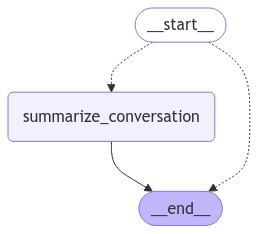

In [9]:
from IPython.display import Image, display

graph = build_summarize_subgraph().compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
def build_graph() -> StateGraph:
    builder = StateGraph(State)
    builder.add_node("assistant", assistant)
    builder.add_node("tools", ToolNode(tool_list))
    builder.add_node("summarization_subgraph", build_summarize_subgraph().compile())
    
    builder.add_edge(START, "assistant")
    builder.add_edge( "assistant", "summarization_subgraph")
    builder.add_conditional_edges("assistant", tools_condition)
    builder.add_edge("tools", "assistant")
    builder.add_edge("summarization_subgraph", END)
    
    return builder



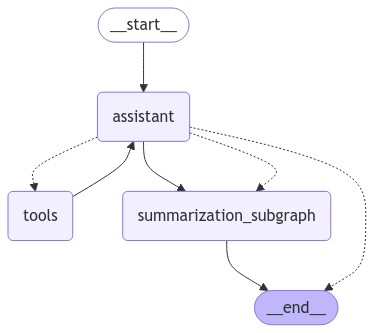

In [11]:
from IPython.display import Image, display

tool_list = [Tools.request_medication_change, Tools.make_appointment, Tools.request_appointment_change]
memory = MemorySaver()
graph = build_graph().compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="My name is Sajed")]
config = {"configurable": {"thread_id": "3"}}
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

In [ ]:
messages = [HumanMessage(content="What is my name?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

In [ ]:
graph.get_state(config).values.get("summary","")

In [ ]:
messages = [HumanMessage(content="What is my name?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

In [ ]:
graph.get_state(config).values.get("summary","")

In [ ]:
messages = [HumanMessage(content="I have an appointmnet on October 9. I want to reschedule it to November 5th.")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

In [ ]:
graph.get_state(thread).values.get("summary","")